In [1]:
#source /scratch/phys/sin/sethih1/venv/MolNexTR_env/bin/activate
import sys
sys.path.append('/home/sethih1/MORAFInator/')

In [2]:
import os 
import sys
import time 
import json
import random
import argparse
import datetime
import numpy as np
import pandas as pd

import torch
import torch.distributed as dist
from torch.optim import Adam, AdamW, SGD
from torch.nn.parallel import DistributedDataParallel as DDP
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from torch.utils.data.distributed import DistributedSampler

from src.components import Encoder, Decoder
from src.loss_fuc import Criterion
from src.utils import seed_torch, save_args, init_summary_writer, LossMeter, AverageMeter, asMinutes, timeSince, print_rank_0, format_df
from src.chemical import convert_graph_to_smiles, postprocess_smiles, keep_main_molecule
from src.tokenization import get_tokenizer
from src.dataloader.data_loader import get_datasets, afm_collate_fn

import warnings 
warnings.filterwarnings('ignore')

/scratch/phys/sin/sethih1/venv/MolNexTR_env/lib64/python3.9/site-packages/onmt/modules/sparse_activations.py:48: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, input, dim=0):
/scratch/phys/sin/sethih1/venv/MolNexTR_env/lib64/python3.9/site-packages/onmt/modules/sparse_activations.py:68: FutureWarning: `torch.cuda.amp.custom_bwd(args...)` is deprecated. Please use `torch.amp.custom_bwd(args..., device_type='cuda')` instead.
  def backward(ctx, grad_output):
/scratch/phys/sin/sethih1/venv/MolNexTR_env/lib64/python3.9/site-packages/onmt/modules/sparse_losses.py:13: FutureWarning: `torch.cuda.amp.custom_fwd(args...)` is deprecated. Please use `torch.amp.custom_fwd(args..., device_type='cuda')` instead.
  def forward(ctx, input, target):
/scratch/phys/sin/sethih1/venv/MolNexTR_env/lib64/python3.9/site-packages/onmt/modules/sparse_losses.py:37: FutureWarning: `torch.cuda.amp.custom_

In [3]:
coord_bins = 64

coord_bin_values = np.round(np.linspace(0,1,64),2)
print(coord_bin_values)
coord_tokens = [f'<COORD_{i}>' for i in range(coord_bins)]

[0.   0.02 0.03 0.05 0.06 0.08 0.1  0.11 0.13 0.14 0.16 0.17 0.19 0.21
 0.22 0.24 0.25 0.27 0.29 0.3  0.32 0.33 0.35 0.37 0.38 0.4  0.41 0.43
 0.44 0.46 0.48 0.49 0.51 0.52 0.54 0.56 0.57 0.59 0.6  0.62 0.63 0.65
 0.67 0.68 0.7  0.71 0.73 0.75 0.76 0.78 0.79 0.81 0.83 0.84 0.86 0.87
 0.89 0.9  0.92 0.94 0.95 0.97 0.98 1.  ]


In [4]:
from types import SimpleNamespace

args_dict = {
    'batch_size': 32,
    'learning_rate': 0.001,

    # related to model encoder
    'encoder': 'swin_base', 
    'use_checkpoint':False, 
    'encoder_dim': 1024, 
    'in_chans': 10,

    # related to model decoder
    'dec_hidden_size': 16,
    'enc_pos_emb': True, 
    'dec_num_layers': 3, 
    'dec_attn_heads': 4,
    'hidden_dropout': 0.2,
    'attn_dropout': 0.2,
    'max_relative_positions': 10,
    'compute_confidence': True,

    # related to tokenizer
    'formats':['atomtok_coords'], #, 'edges'],
    'vocab_file': '/home/sethih1/MORAFInator/src/vocab/vocab_chars.json', 
    'coord_bins': 64, 
    'sep_xy': False, 
    'continuous_coords': True, 
    'input_resolution': 256,

    # loss function
    'label_smoothing': 0.1
    
}

args = SimpleNamespace(**args_dict)
print(args)

tokenizer = get_tokenizer(args)

namespace(batch_size=32, learning_rate=0.001, encoder='swin_base', use_checkpoint=False, encoder_dim=1024, in_chans=10, dec_hidden_size=16, enc_pos_emb=True, dec_num_layers=3, dec_attn_heads=4, hidden_dropout=0.2, attn_dropout=0.2, max_relative_positions=10, compute_confidence=True, formats=['atomtok_coords'], vocab_file='/home/sethih1/MORAFInator/src/vocab/vocab_chars.json', coord_bins=64, sep_xy=False, continuous_coords=True, input_resolution=256, label_smoothing=0.1)


In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device = torch.device(device)
print(device)

cuda


In [6]:
encoder = Encoder(args, pretrained=False).to(device)

In [7]:
from torchsummary import summary
#summary(encoder, input_size=(1, 10, 224, 224))

In [8]:
encoder_dim = encoder.n_features

In [9]:
decoder = Decoder(args, tokenizer)
print(decoder)

Decoder(
  (decoder): ModuleDict(
    (atomtok_coords): TransformerDecoderAR(
      (enc_trans_layer): Sequential(
        (0): Linear(in_features=1024, out_features=16, bias=True)
      )
      (enc_pos_emb): Embedding(144, 1024)
      (decoder): TransformerDecoder(
        (layer_norm): LayerNorm((16,), eps=1e-06, elementwise_affine=True)
        (transformer_layers): ModuleList(
          (0-2): 3 x TransformerDecoderLayer(
            (self_attn): MultiHeadedAttention(
              (linear_keys): Linear(in_features=16, out_features=16, bias=True)
              (linear_values): Linear(in_features=16, out_features=16, bias=True)
              (linear_query): Linear(in_features=16, out_features=16, bias=True)
              (softmax): Softmax(dim=-1)
              (dropout): Dropout(p=0.2, inplace=False)
              (final_linear): Linear(in_features=16, out_features=16, bias=True)
              (relative_positions_embeddings): Embedding(21, 4)
            )
            (feed_forwar

In [10]:
encoder_optimizer = AdamW(encoder.parameters(), lr = 0.001, weight_decay=0.0001)
decoder_optimizer = AdamW(decoder.parameters(), lr= 0.001, weight_decay= 0.0005)

In [17]:
h5_path =  "/scratch/phys/project/sin/hackathon/data/afm.h5"
train_dataset, val_dataset = get_datasets(data_path = h5_path, tokenizer=tokenizer, train_transform = None, val_transform = None, train_size=0.1)

In [18]:
len(train_dataset)

5939

In [19]:
train_loader = DataLoader(train_dataset, batch_size=128, num_workers=2, drop_last = False, collate_fn=afm_collate_fn)

In [20]:
ids, imgs, samples = next(iter(train_loader))

In [21]:
samples['edges']

tensor([[[-100, -100, -100,  ..., -100, -100, -100],
         [-100, -100, -100,  ..., -100, -100, -100],
         [-100, -100, -100,  ..., -100, -100, -100],
         ...,
         [-100, -100, -100,  ..., -100, -100, -100],
         [-100, -100, -100,  ..., -100, -100, -100],
         [-100, -100, -100,  ..., -100, -100, -100]]])

In [22]:
# Training 

def to_device(obj, device):
    """Recursively move tensors inside lists/tuples/dicts to device."""
    if torch.is_tensor(obj):
        return obj.to(device)
    if isinstance(obj, dict):
        return {k: to_device(v, device) for k, v in obj.items()}
    if isinstance(obj, list):
        return [to_device(x, device) for x in obj]
    if isinstance(obj, tuple):
        return tuple(to_device(x, device) for x in obj)
    return obj
    

epochs = 30
encoder.to(device)
decoder.to(device)

criterion = Criterion(args, tokenizer).to(device)
for epoch in range(epochs):
    encoder.train()
    decoder.train()

    losses = []

    for step, (indices, imgs, refs) in enumerate(train_loader):

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        imgs = imgs.to(device)
        #refs = refs.to(device)
        refs = to_device(refs, device)


        features, hiddens = encoder(imgs)

        
        
        #features, hiddens = encoder(imgs, refs)
        results = decoder(features, hiddens, refs)
        losses_dict = criterion(results, refs)
        #print(losses_dict)
        loss = sum(losses_dict.values())
        #torch.autograd.set_detect_anomaly(True)
        loss.backward()
        encoder_optimizer.step()
        decoder_optimizer.step()
        losses.append(loss.item())

    train_loss = torch.mean(torch.tensor(losses))

    print(f"Epoch {epoch+1} training loss: {train_loss}")

Epoch 1 training loss: 1.7043615579605103
Epoch 2 training loss: 1.6692959070205688
Epoch 3 training loss: 1.6041533946990967
Epoch 4 training loss: 1.452243685722351
Epoch 5 training loss: 1.34908926486969
Epoch 6 training loss: 1.294350504875183
Epoch 7 training loss: 1.2714378833770752
Epoch 8 training loss: 1.2608379125595093
Epoch 9 training loss: 1.2545229196548462
Epoch 10 training loss: 1.2502985000610352
Epoch 11 training loss: 1.2468103170394897
Epoch 12 training loss: 1.2439998388290405
Epoch 13 training loss: 1.241685390472412
Epoch 14 training loss: 1.2396807670593262
Epoch 15 training loss: 1.2378507852554321
Epoch 16 training loss: 1.236501932144165
Epoch 17 training loss: 1.2353620529174805
Epoch 18 training loss: 1.234342336654663
Epoch 19 training loss: 1.2331600189208984
Epoch 20 training loss: 1.2325148582458496
Epoch 21 training loss: 1.2315983772277832
Epoch 22 training loss: 1.2309956550598145
Epoch 23 training loss: 1.2299803495407104
Epoch 24 training loss: 1.2

In [28]:
train_loader = DataLoader(train_dataset, batch_size=1, num_workers=2, drop_last = False, collate_fn=afm_collate_fn)

In [70]:
val_loader = DataLoader(val_dataset, batch_size=1, num_workers=2, drop_last = False, collate_fn=afm_collate_fn)

In [71]:
encoder.eval()
decoder.eval()
for step, (indices, imgs, refs) in enumerate(train_loader):

        encoder_optimizer.zero_grad()
        decoder_optimizer.zero_grad()

        imgs = imgs.to(device)
        #refs = refs.to(device)
        refs = to_device(refs, device)


        features, hiddens = encoder(imgs)

        
        
        #features, hiddens = encoder(imgs, refs)
        results = decoder.decode(features, hiddens, refs)
        #print(results)

In [72]:
_, imgs, refs = next(iter(train_loader))

In [73]:
import matplotlib.pyplot as plt

In [74]:
torch.mean(imgs, dim = 1).shape

torch.Size([1, 128, 128])

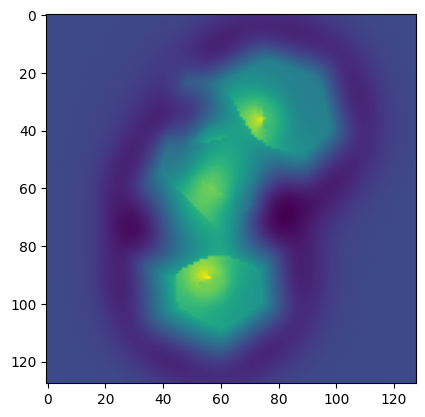

In [75]:
plt.imshow(torch.mean(imgs, dim = 1).squeeze(0).cpu())

In [76]:
t = refs['atomtok_coords'][0].cpu()
t = t[t>0]
t.reshape(-1,4)

RuntimeError: shape '[-1, 4]' is invalid for input of size 86

In [77]:
atomtok_coords = tokenizer['atomtok_coords'].sequence_to_nodes(t.numpy())

In [78]:
atomtok_coords

{'coords': [[0.38095238095238093, 0.6666666666666666],
  [0.6984126984126984, 0.7301587301587301],
  [0.5873015873015873, 0.6031746031746031],
  [1.0, 0.6825396825396826],
  [0.36507936507936506, 0.9365079365079365],
  [1.0, 0.7619047619047619],
  [1.0, 0.5714285714285714],
  [0.3333333333333333, 0.8412698412698413],
  [0.9206349206349206, 0.7619047619047619],
  [0.9206349206349206, 0.5714285714285714],
  [0.4603174603174603, 0.9682539682539683],
  [0.4126984126984127, 0.7619047619047619],
  [0.6825396825396826, 0.5714285714285714],
  [0.5873015873015873, 0.7142857142857143],
  [0.5079365079365079, 0.7936507936507936],
  [0.8571428571428571, 0.6666666666666666],
  [0.746031746031746, 0.6507936507936508],
  [0.5396825396825397, 0.8888888888888888],
  [1.0, 0.8412698412698413],
  [1.0, 0.5079365079365079],
  [0.49206349206349204, 1.0],
  [0.25396825396825395, 0.8095238095238095],
  [0.6190476190476191, 0.9206349206349206],
  [0.8888888888888888, 0.49206349206349204],
  [0.698412698412698

In [79]:
results

[{'atomtok_coords': {'smiles': 'F<unk>F<unk>F<unk>F<unk>F<unk>F<unk>',
   'symbols': ['F',
    '<unk>',
    'F',
    '<unk>',
    'F',
    '<unk>',
    'F',
    '<unk>',
    'F',
    '<unk>',
    'F',
    '<unk>'],
   'indices': [3, 6, 9, 12, 15, 18, 21, 24, 27, 30, 33, 36],
   'atom_scores': [0.0697278082370758,
    0.06669189035892487,
    0.06551497429609299,
    0.06055302172899246,
    0.06222889572381973,
    0.04862992838025093,
    0.052132606506347656,
    0.038372695446014404,
    0.0476510152220726,
    0.03581980988383293,
    0.04535748064517975,
    0.03542545437812805],
   'average_token_score': 0.1415097862482071}}]

In [43]:
print(results['atomtok_coords'][0].shape)

TypeError: list indices must be integers or slices, not str

In [ ]:
def predict_images(self, input_images: List, return_atoms_bonds=False, return_confidence=False, batch_size=16):
        device = self.device
        predictions = []
        decoder.compute_confidence = return_confidence

        for idx in range(0, len(input_images), batch_size):
            batch_images = input_images[idx:idx+batch_size]
            images = [self.transform(image=image, keypoints=[])['image'] for image in batch_images]
            images = torch.stack(images, dim=0).to(device)
            with torch.no_grad():
                features, hiddens = self.encoder(images)
                batch_predictions = self.decoder.decode(features, hiddens)
            predictions += batch_predictions

        node_coords = [pred['chartok_coords']['coords'] for pred in predictions]
        node_symbols = [pred['chartok_coords']['symbols'] for pred in predictions]
        edges = [pred['edges'] for pred in predictions]

        smiles_list, molblock_list, r_success = convert_graph_to_smiles(
            node_coords, node_symbols, edges, images=input_images)

        outputs = []
        for smiles, molfile, pred in zip(smiles_list, molblock_list, predictions):
            pred_dict = {"predicted_smiles": smiles, "predicted_molfile": molfile}
            if return_atoms_bonds:
                coords = pred['chartok_coords']['coords']
                symbols = pred['chartok_coords']['symbols']
                # get atoms info
                atom_list = []
                for i, (symbol, coord) in enumerate(zip(symbols, coords)):
                    atom_dict = {"atom_number":f"{i}", "atom_symbol": symbol, "coords":(round(coord[0],3),round(coord[1],3))}
                    if return_confidence:
                        atom_dict["confidence"] = pred['chartok_coords']['atom_scores'][i]
                    atom_list.append(atom_dict)
                pred_dict["atom_sets"] = atom_list
                # get bonds info
                bond_list = []
                num_atoms = len(symbols)
                for i in range(num_atoms-1):
                    for j in range(i+1, num_atoms):
                        bond_type_int = pred['edges'][i][j]
                        if bond_type_int != 0:
                            bond_type_str = BOND_TYPES[bond_type_int]
                            bond_dict = {"atom_number":f"{i}","bond_type": bond_type_str, "endpoints": (i, j)}
                            if return_confidence:
                                bond_dict["confidence"] = pred["edge_scores"][i][j]
                            bond_list.append(bond_dict)
                pred_dict["bond_sets"] = bond_list
            outputs.append(pred_dict)
        return outputs

In [41]:
predictions = model.predict_final_results(imgs, return_atoms_bonds=False)

NameError: name 'model' is not defined

In [30]:
data = create_3d_dataloader(h5_path, batch_size=1, num_workers=1)

NameError: name 'create_3d_dataloader' is not defined

In [ ]:


    def getitem(self, idx):
        ref = {}
        if self.dynamic_indigo:
            begin = time.time()
            image, smiles, graph, success = generate_indigo_image(
                self.smiles[idx], mol_augment=self.args.mol_augment, default_option=self.args.default_option,
                shuffle_nodes=self.args.shuffle_nodes, pseudo_coords=self.pseudo_coords,
                include_condensed=self.args.include_condensed)
            # raw_image = image
            end = time.time()
            if idx < 30 and self.args.save_image:
                path = os.path.join(self.args.save_path, 'images')
                os.makedirs(path, exist_ok=True)
                cv2.imwrite(os.path.join(path, f'{idx}.png'), image)
            if not success:
                return idx, None, {}
            image, coords = self.image_transform(image, graph['coords'], renormalize=self.pseudo_coords)
            graph['coords'] = coords
            ref['time'] = end - begin
            if 'atomtok' in self.formats:
                max_len = FORMAT_INFO['atomtok']['max_len']
                label = self.tokenizer['atomtok'].text_to_sequence(smiles, tokenized=False)
                ref['atomtok'] = torch.LongTensor(label[:max_len])
            if 'edges' in self.formats and 'atomtok_coords' not in self.formats and 'chartok_coords' not in self.formats:
                ref['edges'] = torch.tensor(graph['edges'])
            if 'atomtok_coords' in self.formats:
                self._process_atomtok_coords(idx, ref, smiles, graph['coords'], graph['edges'],
                                             mask_ratio=self.args.mask_ratio)
            if 'chartok_coords' in self.formats:
                self._process_chartok_coords(idx, ref, smiles, graph['coords'], graph['edges'],
                                             mask_ratio=self.args.mask_ratio)
            return idx, image, ref
        else:
            file_path = self.file_paths[idx]
            image = cv2.imread(file_path)
            if image is None:
                image = np.array([[[255., 255., 255.]] * 10] * 10).astype(np.float32)
                print(file_path, 'not found!')
            if self.coords_df is not None:
                h, w, _ = image.shape
                coords = np.array(eval(self.coords_df.loc[idx, 'node_coords']))
                if self.pseudo_coords:
                    coords = normalize_nodes(coords)
                coords[:, 0] = coords[:, 0] * w
                coords[:, 1] = coords[:, 1] * h
                image, coords = self.image_transform(image, coords, renormalize=self.pseudo_coords)
            else:
                image = self.image_transform(image)
                coords = None
            if self.labelled:
                smiles = self.smiles[idx]
                if 'atomtok' in self.formats:
                    max_len = FORMAT_INFO['atomtok']['max_len']
                    label = self.tokenizer['atomtok'].text_to_sequence(smiles, False)
                    ref['atomtok'] = torch.LongTensor(label[:max_len])
                if 'atomtok_coords' in self.formats:
                    if coords is not None:
                        self._process_atomtok_coords(idx, ref, smiles, coords, mask_ratio=0)
                    else:
                        self._process_atomtok_coords(idx, ref, smiles, mask_ratio=1)
                if 'chartok_coords' in self.formats:
                    if coords is not None:
                        self._process_chartok_coords(idx, ref, smiles, coords, mask_ratio=0)
                    else:
                        self._process_chartok_coords(idx, ref, smiles, mask_ratio=1)
            if self.args.predict_coords and ('atomtok_coords' in self.formats or 'chartok_coords' in self.formats):
                smiles = self.smiles[idx]
                if 'atomtok_coords' in self.formats:
                    self._process_atomtok_coords(idx, ref, smiles, mask_ratio=1)
                if 'chartok_coords' in self.formats:
                    self._process_chartok_coords(idx, ref, smiles, mask_ratio=1)
            return idx, image, ref

    def _process_atomtok_coords(self, idx, ref, smiles, coords=None, edges=None, mask_ratio=0):
        max_len = FORMAT_INFO['atomtok_coords']['max_len']
        tokenizer = self.tokenizer['atomtok_coords']
        if smiles is None or type(smiles) is not str:
            smiles = ""
        label, indices = tokenizer.smiles_to_sequence(smiles, coords, mask_ratio=mask_ratio)
        ref['atomtok_coords'] = torch.LongTensor(label[:max_len])
        indices = [i for i in indices if i < max_len]
        ref['atom_indices'] = torch.LongTensor(indices)
        if tokenizer.continuous_coords:
            if coords is not None:
                ref['coords'] = torch.tensor(coords)
            else:
                ref['coords'] = torch.ones(len(indices), 2) * -1.
        if edges is not None:
            ref['edges'] = torch.tensor(edges)[:len(indices), :len(indices)]
        else:
            if 'edges' in self.df.columns:
                edge_list = eval(self.df.loc[idx, 'edges'])
                n = len(indices)
                edges = torch.zeros((n, n), dtype=torch.long)
                for u, v, t in edge_list:
                    if u < n and v < n:
                        if t <= 4:
                            edges[u, v] = t
                            edges[v, u] = t
                        else:
                            edges[u, v] = t
                            edges[v, u] = 11 - t
                ref['edges'] = edges
            else:
                ref['edges'] = torch.ones(len(indices), len(indices), dtype=torch.long) * (-100)

    def _process_chartok_coords(self, idx, ref, smiles, coords=None, edges=None, mask_ratio=0):
        max_len = FORMAT_INFO['chartok_coords']['max_len']
        tokenizer = self.tokenizer['chartok_coords']
        if smiles is None or type(smiles) is not str:
            smiles = ""
        label, indices = tokenizer.smiles_to_sequence(smiles, coords, mask_ratio=mask_ratio)
        ref['chartok_coords'] = torch.LongTensor(label[:max_len])
        indices = [i for i in indices if i < max_len]
        ref['atom_indices'] = torch.LongTensor(indices)
        if tokenizer.continuous_coords:
            if coords is not None:
                ref['coords'] = torch.tensor(coords)
            else:
                ref['coords'] = torch.ones(len(indices), 2) * -1.
        if edges is not None:
            ref['edges'] = torch.tensor(edges)[:len(indices), :len(indices)]
        else:
            if 'edges' in self.df.columns:
                edge_list = eval(self.df.loc[idx, 'edges'])
                n = len(indices)
                edges = torch.zeros((n, n), dtype=torch.long)
                for u, v, t in edge_list:
                    if u < n and v < n:
                        if t <= 4:
                            edges[u, v] = t
                            edges[v, u] = t
                        else:
                            edges[u, v] = t
                            edges[v, u] = 11 - t
                ref['edges'] = edges
            else:
                ref['edges'] = torch.ones(len(indices), len(indices), dtype=torch.long) * (-100)


In [ ]:

# NEW: map element indices (from AFMData) to atomic symbols used by tokenizer
INDEX_TO_SYMBOL = {
    0: 'H',
    1: 'C',
    2: 'N',
    3: 'O',
    4: 'F',
}

class AFM3DToChartokConverter:
    """3D AFM to ChartTok converter for training"""
    
    def __init__(self, tokenizer, coord_bins=64, default_atom='C', use_3d=True):
        self.tokenizer = tokenizer
        self.coord_bins = coord_bins
        self.default_atom = default_atom
        self.use_3d = use_3d
        
        # Create coordinate tokens (bins for X, Y, Z)
        self.coord_tokens = [f'<COORD_{i}>' for i in range(coord_bins)]
    
    def coords_3d_to_token_sequence(self, coords_3d, symbols):
        """Convert 3D coordinates and symbols to token sequence (symbols + SOS/EOS)."""
        if coords_3d is None or len(coords_3d) == 0 or len(symbols) == 0:
            return torch.tensor([1, 2], dtype=torch.long)  # SOS, EOS
        
        sequence = [1]  # SOS token
        
        for symbol in symbols:
            if symbol in self.tokenizer.stoi:
                sequence.append(self.tokenizer.stoi[symbol])
            else:
                sequence.append(self.tokenizer.stoi.get(self.default_atom, UNK_ID))
        
        sequence.append(2)  # EOS
        return torch.tensor(sequence, dtype=torch.long)
    
    def _normalize_coords_3d(self, coords):
        """Normalize 3D coordinates to [0, 1] range"""
        coords = np.array(coords)
        if len(coords) == 0:
            return coords
        
        # Per-dimension normalization
        coords_norm = np.zeros_like(coords)
        for dim in range(3):
            coord_dim = coords[:, dim]
            min_val, max_val = coord_dim.min(), coord_dim.max()
            if max_val > min_val:
                coords_norm[:, dim] = (coord_dim - min_val) / (max_val - min_val)
            else:
                coords_norm[:, dim] = 0.5  # Default to middle if all same
        
        return coords_norm
    
    def convert_single_molecule_3d(self, nodes, edges=None):
        """Convert single AFM molecule to 3D chartok format"""
        if hasattr(nodes, 'x') and hasattr(nodes, 'pos'):
            # PyTorch Geometric format
            symbols = [self.default_atom] * len(nodes.x)  # Simplified - use default atom
            coords_3d = nodes.pos.numpy() if hasattr(nodes.pos, 'numpy') else nodes.pos
        elif isinstance(nodes, dict):
            # Dictionary format
            if 'pos' in nodes and 'x' in nodes:
                coords_3d = nodes['pos']
                symbols = [self.default_atom] * len(coords_3d)
            else:
                # Default fallback
                coords_3d = np.random.rand(5, 3)  # Random 3D positions
                symbols = [self.default_atom] * 5
        else:
            # Tensor or array format
            if hasattr(nodes, 'shape') and len(nodes.shape) >= 2:
                if nodes.shape[-1] >= 3:
                    coords_3d = nodes[:, :3] if len(nodes.shape) == 2 else nodes.reshape(-1, 3)[:, :3]
                    symbols = [self.default_atom] * len(coords_3d)
                else:
                    # Fallback to random
                    coords_3d = np.random.rand(5, 3)
                    symbols = [self.default_atom] * 5
            else:
                coords_3d = np.random.rand(5, 3)
                symbols = [self.default_atom] * 5
        
        # Convert to token sequence
        token_sequence = self.coords_3d_to_token_sequence(coords_3d, symbols)
        
        # Create info dict
        nodes_3d_dict = {
            'coords_3d': coords_3d.tolist() if hasattr(coords_3d, 'tolist') else coords_3d,
            'symbols': symbols,
            'num_atoms': len(symbols)
        }
        
        return token_sequence, nodes_3d_dict

# NEW: Dataset wrapper that uses AFMData (HDF5) and converts to model-friendly items
class H5AFM3DDataset(Dataset):
    def __init__(self, h5_path, tokenizer, coord_bins=64):
        super().__init__()
        self.afm = AFMData(h5_path, transform=None, train_size=1.0, split='train')
        self.converter = AFM3DToChartokConverter(tokenizer, coord_bins=coord_bins, default_atom='C', use_3d=True)
    def __len__(self):
        return len(self.afm)
    def __getitem__(self, idx):
        idx_out, image, sample = self.afm[idx]
        # sample['coords']: numpy array [num_atoms, 5] -> x,y,z,charge?,element_index(0..4)
        coords_np = sample['coords']
        edges_np = sample['edges']  # (E, 2)
        coords_3d = torch.from_numpy(coords_np[:, :3]).float() if coords_np.size > 0 else torch.zeros((0, 3), dtype=torch.float32)
        # derive symbols from last column (already mapped to 0..4)
        elem_idx = coords_np[:, -1].astype(int) if coords_np.size > 0 else np.array([], dtype=int)
        symbols = [INDEX_TO_SYMBOL.get(int(i), 'C') for i in elem_idx]
        # build token sequence for chartok_coords
        sequence = self.converter.coords_3d_to_token_sequence(coords_3d.numpy(), symbols)
        return {
            'idx': torch.tensor(idx_out, dtype=torch.long),
            'image': image,                         # tensor [3,H,W]
            'sequence': sequence,                   # tensor [T]
            'seq_length': torch.tensor(len(sequence), dtype=torch.long),
            'coords_3d': coords_3d,                 # tensor [N,3]
            'symbols': symbols,
            'num_atoms': torch.tensor(len(symbols), dtype=torch.long),
            'edges_list': torch.from_numpy(edges_np).long() if edges_np.size > 0 else torch.zeros((0, 2), dtype=torch.long),
        }

class Complete3DAFMDataset:
    """Complete 3D AFM dataset wrapper"""
    
    def __init__(self, afm_dataset, tokenizer, coord_bins=64, default_atom='C', use_3d=True):
        self.afm_dataset = afm_dataset
        self.converter = AFM3DToChartokConverter(tokenizer, coord_bins, default_atom, use_3d)
        self.cache = {}
    
    def __len__(self):
        return len(self.afm_dataset)
    
    def __getitem__(self, idx):
        if idx in self.cache:
            return self.cache[idx]
        
        # Get AFM sample
        afm_sample = self.afm_dataset[idx]
        
        # Extract molecular data
        nodes = afm_sample.get('nodes', afm_sample.get('x', None))
        edges = afm_sample.get('edges', None)
        
        if nodes is not None:
            chartok_3d_seq, nodes_3d_dict = self.converter.convert_single_molecule_3d(nodes, edges)
            
            converted_sample = {
                'idx': idx,
                'chartok_coords_3d': chartok_3d_seq,
                'nodes_3d_dict': nodes_3d_dict,
                'original_afm_sample': afm_sample,
                'coords_3d': torch.tensor(nodes_3d_dict['coords_3d'], dtype=torch.float32),
                'symbols': nodes_3d_dict['symbols']
            }
        else:
            # Fallback
            converted_sample = {
                'idx': idx,
                'chartok_coords_3d': torch.tensor([1, 2]),
                'nodes_3d_dict': {'coords_3d': [], 'symbols': []},
                'original_afm_sample': afm_sample,
                'coords_3d': torch.tensor([]),
                'symbols': []
            }
        
        self.cache[idx] = converted_sample
        return converted_sample

class AFM3DCollator:
    """Custom collate function for 3D AFM data"""
    
    def __init__(self, tokenizer, max_length=256):
        self.tokenizer = tokenizer
        self.max_length = max_length
    
    def __call__(self, batch):
        batch_size = len(batch)
        
        sequences = [sample['chartok_coords_3d'] for sample in batch]
        coords_3d_list = [sample['coords_3d'] for sample in batch]
        symbols_list = [sample['symbols'] for sample in batch]
        
        # Pad sequences
        max_seq_len = min(max(len(seq) for seq in sequences), self.max_length)
        padded_sequences = torch.zeros((batch_size, max_seq_len), dtype=torch.long)
        attention_masks = torch.zeros((batch_size, max_seq_len), dtype=torch.bool)
        
        # 3D coordinates
        max_atoms = max(len(coords) for coords in coords_3d_list) if coords_3d_list[0].numel() > 0 else 1
        coords_3d_batch = torch.zeros((batch_size, max_atoms, 3))
        coords_mask = torch.zeros((batch_size, max_atoms), dtype=torch.bool)
        
        for i, (seq, coords_3d, symbols) in enumerate(zip(sequences, coords_3d_list, symbols_list)):
            seq_len = min(len(seq), max_seq_len)
            padded_sequences[i, :seq_len] = seq[:seq_len]
            attention_masks[i, :seq_len] = True
            
            if coords_3d.numel() > 0 and len(coords_3d.shape) == 2:
                atom_len = min(len(coords_3d), max_atoms)
                coords_3d_batch[i, :atom_len] = coords_3d[:atom_len]
                coords_mask[i, :atom_len] = True
        
        return {
            'input_ids': padded_sequences,
            'attention_mask': attention_masks,
            'coords_3d': coords_3d_batch,
            'coords_mask': coords_mask,
            'symbols_batch': symbols_list,
            'batch_size': batch_size,
            'max_seq_len': max_seq_len,
            'max_atoms': max_atoms
        }

def make_collate_fn(tokenizer):
    """Create a collate function that maps out-of-range tokens to UNK and batches coords/edges."""
    vocab_size = len(tokenizer)
    base_vocab = len(tokenizer.stoi)

    def _collate(batch):
        # indices and images
        indices = torch.stack([item['idx'] for item in batch])
        images = torch.stack([item['image'] for item in batch])

        # sequences with UNK clamping
        raw_sequences = [item['sequence'] for item in batch]
        sequences = []
        seq_lengths = []
        for seq in raw_sequences:
            seq = seq.clone()
            invalid = (seq >= vocab_size) | (seq < 0)
            if invalid.any():
                seq[invalid] = UNK_ID
            sequences.append(seq)
            seq_lengths.append(torch.tensor(len(seq), dtype=torch.long))
        seq_lengths = torch.stack(seq_lengths)

        # debug token range for first few batches
        all_tokens = torch.cat(sequences) if len(sequences) > 0 else torch.tensor([], dtype=torch.long)
        if all_tokens.numel() > 0:
            max_token = all_tokens.max().item(); min_token = all_tokens.min().item()
        else:
            max_token = min_token = 0
        if not hasattr(_collate, 'call_count'):
            _collate.call_count = 0
        _collate.call_count += 1
        if _collate.call_count <= 3:
            logger.info(f"🔍 Batch {_collate.call_count}: Token range [{min_token}, {max_token}], base_vocab={base_vocab}, total_vocab={vocab_size}, sequences={len(sequences)}")

        # pad sequences
        max_len = max(len(seq) for seq in sequences) if sequences else 0
        batch_size = len(batch)
        padded_sequences = torch.zeros(batch_size, max_len, dtype=torch.long)
        for i, seq in enumerate(sequences):
            L = len(seq)
            if L > 0:
                padded_sequences[i, :L] = seq

        # coords_3d batching (pad to max atoms), use -100 for masked positions
        coords_list = [item['coords_3d'] for item in batch]
        num_atoms_list = [int(item['num_atoms']) for item in batch]
        max_atoms = max(num_atoms_list) if num_atoms_list else 0
        coords_3d_batch = torch.full((batch_size, max_atoms, 3), -100.0, dtype=torch.float32)
        for i, coords in enumerate(coords_list):
            n = min(coords.size(0), max_atoms)
            if n > 0:
                coords_3d_batch[i, :n, :] = coords[:n, :]

        # atom_indices: positions of symbol tokens in sequence: [1..num_atoms]
        atom_indices = torch.zeros(batch_size, max_atoms, dtype=torch.long)
        for i, n_atoms in enumerate(num_atoms_list):
            n = min(n_atoms, max_atoms)
            if n > 0:
                atom_indices[i, :n] = torch.arange(1, 1 + n)

        # edges target placeholder: ignore all pairs by default (-100), shape [B, max_atoms, max_atoms]
        edges_target = torch.full((batch_size, max_atoms, max_atoms), -100, dtype=torch.long)

        refs = {
            'chartok_coords': (padded_sequences, seq_lengths),
            'coords_3d': coords_3d_batch,
            'edges': edges_target,
            'atom_indices': (atom_indices,),
        }
        return indices, images, refs

    return _collate

def create_3d_dataloader(data_path, batch_size=16, num_workers=4):
    """Create DataLoader for 3D AFM training from HDF5 using the provided pipeline"""
    args = create_model_args()

    # Determine HDF5 file path
    h5_path = data_path
    if os.path.isdir(data_path):
        # pick the first .h5 file in the directory
        h5_files = [os.path.join(data_path, f) for f in os.listdir(data_path) if f.endswith('.h5') or f.endswith('.hdf5')]
        if len(h5_files) == 0:
            raise FileNotFoundError(f"No .h5/.hdf5 files found under {data_path}")
        h5_path = sorted(h5_files)[0]

    # Build tokenizer(s)
    tokenizers = get_tokenizer(args)
    chartok_tok = tokenizers['chartok_coords']
    logger.info(f"📚 Tokenizer built: chartok_coords | base_vocab={len(chartok_tok.stoi)} | total_vocab={len(chartok_tok)} | coord_bins={args.coord_bins}")

    # Create dataset from HDF5
    dataset = H5AFM3DDataset(h5_path, chartok_tok, coord_bins=args.coord_bins)
    logger.info(f"📂 Using AFM HDF5 dataset: {h5_path} | {len(dataset)} samples")

    # Collate function
    collate_fn = make_collate_fn(chartok_tok)

    train_loader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=0,
        pin_memory=True,
        collate_fn=collate_fn
    )

    logger.info(f"✅ DataLoader created with {len(dataset)} samples, {len(train_loader)} batches")
    return train_loader, tokenizers, dataset
